In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(28)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [16]:
client

Client Scheduler: tcp://10.148.1.6:59698 Dashboard: http://10.148.1.6:8787/status,Cluster Workers: 16 Cores: 64 Memory: 800.00 GB


---


# 1. Data files
#### important faces: 1, 2, 4, 5, 7, 8, 10, 11
#### other faces (polar regions): 0, 3, 6, 9, 12

In [5]:
### Here we need to load both SSU and SSV to generate the complex format of horizontal velocoty for rotary spectral calculations, u+iv

v_u = 'SSU'
v_v = 'SSV'

## data files (SSU,SSV) ##
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC1080/'

## dir where spectra will be stored
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/subsampling/'

print(data_dir)
print(E_dir)

/home1/scratch/xyu/mit_zarr/UV/LLC1080/
/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/subsampling/


## Grid

### LLC1080

In [8]:
# grid file
mgrid = xr.open_dataset('/home1/scratch/xyu/grid/mit_grid_t_1080.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','dxG','dyG','dxC','dyC','rAw','rAs','rAz'])
print(mgrid)

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, i, j) float32 ...
    YC       (face, i, j) float32 ...
    CS       (face, i, j) float32 ...
    SN       (face, i, j) float32 ...
    rA       (face, i, j) float32 ...
    Depth    (face, i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


## subsampling data and save 

In [9]:
face_all = [0, 1, 2, 4, 5, 7, 8, 10, 11]

In [10]:
face = face_all

#Grid #
grid = mgrid.isel(face=face)
    
# Read SSU #
D = [xr.open_zarr(data_dir+'SSU_f%02d.zarr'%(face)).rename({'i_g': 'i'}) for face in face_all]
ds_SSU = xr.concat(D, dim='face')
chunks={'time': 1440,'i': 108, 'j': 108} # time chunck: (2 months)
ds_SSU = ds_SSU.chunk(chunks) 

# Read SSV #
D = [xr.open_zarr(data_dir+'SSV_f%02d.zarr'%(face)).rename({'j_g': 'j'}) for face in face_all]
ds_SSV = xr.concat(D, dim='face')
chunks={'time': 1440,'i': 108, 'j': 108} # time chunck: (2 months)
ds_SSV = ds_SSV.chunk(chunks) 

In [11]:
uv_complex = (ds_SSU['SSU'] + 1j*ds_SSV['SSV'])
uv_complex= uv_complex.rename('uv_complex')
uv_complex.to_dataset()
print(uv_complex)
print('\n data size: %.1f GB' %(uv_complex.nbytes / 1e9))

<xarray.DataArray 'uv_complex' (face: 9, time: 8640, j: 1080, i: 1080)>
dask.array<shape=(9, 8640, 1080, 1080), dtype=complex64, chunksize=(1, 1440, 108, 108)>
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * face     (face) int64 0 1 2 4 5 7 8 10 11

 data size: 725.6 GB


In [12]:
subset_factor = 12

ds_subset = (xr.merge([grid, uv_complex])
               .isel(j=slice(0 ,None, subset_factor), i=slice(0, None, subset_factor))
               .chunk({'time': 1440, 'i':1080/subset_factor, 'j':1080/subset_factor})) 

print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (face: 9, i: 90, j: 90, time: 8640)
Coordinates:
  * i           (i) int64 0 48 96 144 192 240 288 336 384 432 480 528 576 ...
  * j           (j) int64 0 48 96 144 192 240 288 336 384 432 480 528 576 ...
  * face        (face) int64 0 1 2 4 5 7 8 10 11
    XC          (face, i, j) float32 dask.array<shape=(9, 90, 90), chunksize=(9, 90, 90)>
    YC          (face, i, j) float32 dask.array<shape=(9, 90, 90), chunksize=(9, 90, 90)>
    CS          (face, i, j) float32 dask.array<shape=(9, 90, 90), chunksize=(9, 90, 90)>
    SN          (face, i, j) float32 dask.array<shape=(9, 90, 90), chunksize=(9, 90, 90)>
    rA          (face, i, j) float32 dask.array<shape=(9, 90, 90), chunksize=(9, 90, 90)>
    Depth       (face, i, j) float32 dask.array<shape=(9, 90, 90), chunksize=(9, 90, 90)>
    dtime       (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
  * time        (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
Data variables:


In [13]:
file_E = E_dir+'ds_subset.zarr'
%time ds_subset.to_zarr(file_E, mode='w')  

CPU times: user 12min 30s, sys: 40.9 s, total: 13min 11s
Wall time: 14min 41s


__________
# 2. FFT

### Following  Ryan's https://gist.github.com/rabernat/fd2522f1937a43f49ac0423d35915648

#### The big difference is to turn the 4D data (time,face,i,j) into a 2D dataset (time, point).

In [6]:
### Here we need to load both SSU and SSV to generate the complex format of horizontal velocoty for rotary spectral calculations, u+iv

## data files (SSU,SSV) ##
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC1080/'

## dir where spectra will be stored
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/subsampling/'

print(data_dir)
print(E_dir)

/home1/scratch/xyu/mit_zarr/UV/LLC1080/
/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/subsampling/


In [7]:
ds = xr.open_zarr(E_dir+'ds_subset.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (face: 9, i: 90, j: 90, time: 8640)
Coordinates:
    CS          (face, i, j) float32 dask.array<shape=(9, 90, 90), chunksize=(9, 90, 90)>
    Depth       (face, i, j) float32 dask.array<shape=(9, 90, 90), chunksize=(9, 90, 90)>
    SN          (face, i, j) float32 dask.array<shape=(9, 90, 90), chunksize=(9, 90, 90)>
    XC          (face, i, j) float32 dask.array<shape=(9, 90, 90), chunksize=(9, 90, 90)>
    YC          (face, i, j) float32 dask.array<shape=(9, 90, 90), chunksize=(9, 90, 90)>
    dtime       (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(8640,)>
  * face        (face) int64 0 1 2 4 5 7 8 10 11
  * i           (i) int64 0 48 96 144 192 240 288 336 384 432 480 528 576 ...
  * j           (j) int64 0 48 96 144 192 240 288 336 384 432 480 528 576 ...
    rA          (face, i, j) float32 dask.array<shape=(9, 90, 90), chunksize=(9, 90, 90)>
  * time        (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
Data variables:


In [8]:
ds_subset = (ds.stack(point=['face','j', 'i'])
               .chunk({'time': 1440, 'point': 10000}))
print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (point: 72900, time: 8640)
Coordinates:
    CS          (point) float32 dask.array<shape=(72900,), chunksize=(10000,)>
    Depth       (point) float32 dask.array<shape=(72900,), chunksize=(10000,)>
    SN          (point) float32 dask.array<shape=(72900,), chunksize=(10000,)>
    XC          (point) float32 dask.array<shape=(72900,), chunksize=(10000,)>
    YC          (point) float32 dask.array<shape=(72900,), chunksize=(10000,)>
    dtime       (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
    rA          (point) float32 dask.array<shape=(72900,), chunksize=(10000,)>
  * time        (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
  * point       (point) MultiIndex
  - face        (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - j           (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - i           (point) int64 0 48 96 144 192 240 288 336 384 432 480 528 ...
Data variables:
    uv_

In [15]:
# constant detrending, windowig
uv_fft_complex = xrft.dft(ds_subset.uv_complex.where(ds_subset.Depth>1000).fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=True)
E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv = E_uv_segments.mean(dim=['time_segment']) 
E_uv = E_uv.assign_coords(freq_cpd=E_uv.freq_time * 86400.) 
E_uv = np.real(E_uv).rename('E_uv')

E_uv_zonmean = (E_uv.groupby_bins(ds_subset['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))
E_llc_constant_window = E_uv_zonmean.chunk({'freq_time': 1440, 'YC_bins': 1})
E_llc_constant_window = np.real(E_llc_constant_window).rename('E_llc_constant_window')
file_E = E_dir+'E_llc_constant_window.zarr'
%time E_llc_constant_window.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 5.02 s, sys: 260 ms, total: 5.28 s
Wall time: 17 s


In [17]:
# linear detrending, windowing
uv_fft_complex = xrft.dft(ds_subset.uv_complex.where(ds_subset.Depth>1000).fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=True)
E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv = E_uv_segments.mean(dim=['time_segment']) 
E_uv = E_uv.assign_coords(freq_cpd=E_uv.freq_time * 86400.) 
E_uv = np.real(E_uv).rename('E_uv')

E_uv_zonmean = (E_uv.groupby_bins(ds_subset['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))
E_llc_linear_window = E_uv_zonmean.chunk({'freq_time': 1440, 'YC_bins': 1}) #.load()
E_llc_linear_window = np.real(E_llc_linear_window).rename('E_llc_linear_window')
file_E = E_dir+'E_llc_linear_window.zarr'
%time E_llc_linear_window.to_dataset().to_zarr(file_E, mode='w')  

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1230, in time
    out = eval(code, glob, local_ns)
  File "<timed eval>", line 1, in <module>
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/core/dataset.py", line 1187, in to_zarr
    group=group, encoding=encoding, compute=compute)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/backends/api.py", line 858, in to_zarr
    dataset.dump_to_store(store, sync=True, encoding=encoding, compute=compute)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/core/dataset.py", line 1077, in dump_to_store
    store.sync(compute=compute)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/backends/zarr.py", line 346, in sync
    self.delayed_store = self.writer.sync(compute=compute)
  File "/hom

KeyboardInterrupt: 

______
# 3. Figure

In [13]:
ds = xr.open_zarr(E_dir+'E_llc_linear_window.zarr')#.chunk({'freq_time': 1440, 'lat_bins': 1}) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:              (YC_bins: 121, freq_time: 1440)
Coordinates:
  * YC_bins              (YC_bins) int64 -60 -59 -58 -57 -56 -55 -54 -53 -52 ...
    freq_cpd             (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time            (freq_time) float64 0.0 1.929e-07 3.858e-07 ...
    freq_time_spacing    float64 ...
Data variables:
    E_llc_linear_window  (freq_time, YC_bins) float64 dask.array<shape=(1440, 121), chunksize=(1440, 1)>

 data size: 0.0 GB


Text(0.5,1,'LLC')

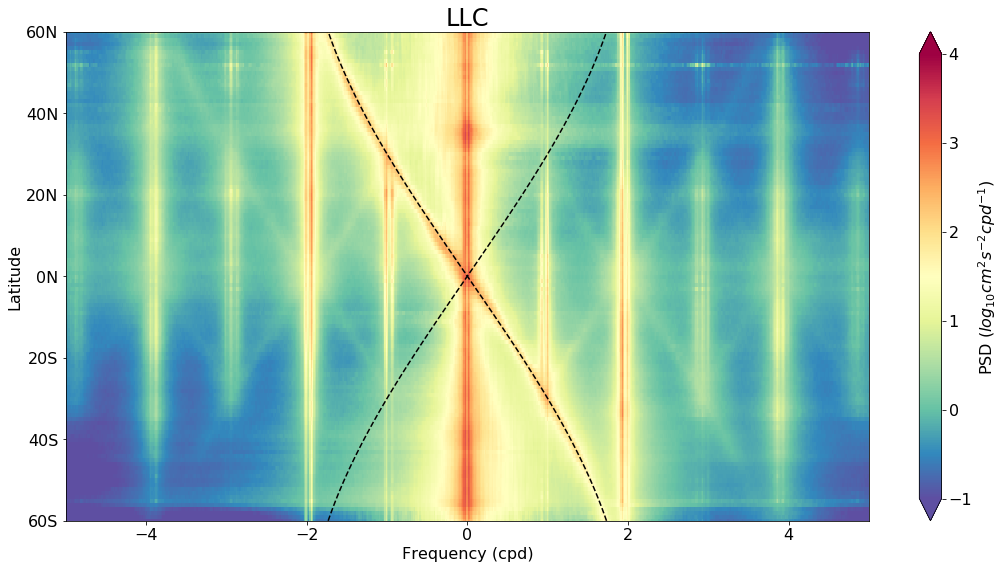

In [14]:

E_llc_linear_window = ds.E_llc_linear_window

plt.figure(figsize=(18,9))

## Drifter
ax = plt.subplot(1,1,1)
cax = np.log10(E_llc_linear_window.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='YC_bins', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16) 
# x,y ticks
#ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)
# add coriolis frequency
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_llc_linear_window.YC_bins))
ax.plot(f_llc*86400./2./np.pi,f_llc.YC_bins,'k--')
ax.plot(-f_llc*86400./2./np.pi,f_llc.YC_bins,'k--')
ax.set_title('LLC',fontsize=24)


In [20]:
E = ds.E_llc_linear_window
df=E.freq_time[1]-E.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)
Coordinates:
    freq_time_spacing  float64 1.929e-07


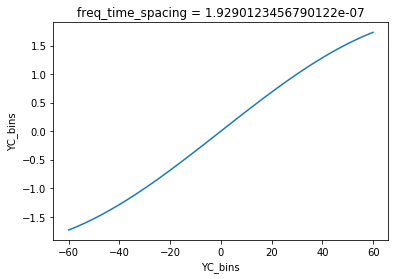

In [21]:
# Inertial frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC_bins))
f_cpd = f*86400/2./np.pi
f_cpd.plot()

## Total energy vs Band-frequency integral

### open ocean

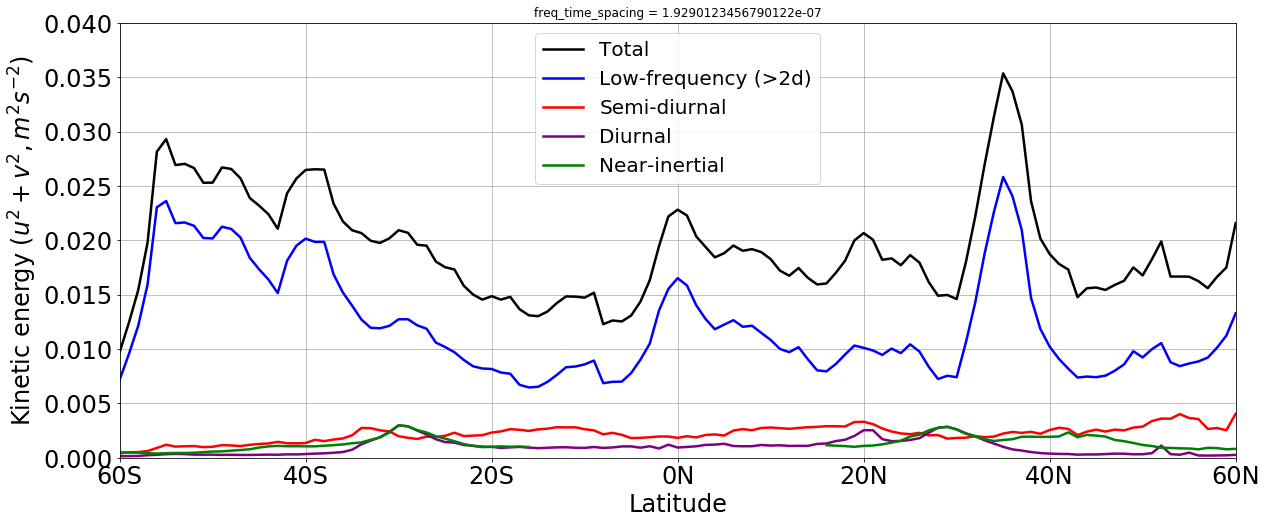

In [22]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']


(E*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E.YC_bins)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.04])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

In [19]:
cluster.scheduler.close()

<Future finished result=None>